In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='BK')
### HAMILTONIAN end

#####################################

QubitHamiltonian

(-0.32760818995565577+0j) [] +
(0.04919764587885283+0j) [X0 Z1 X2] +
(0.04919764587885283+0j) [X0 Z1 X2 Z3] +
(0.04919764587885283+0j) [Y0 Z1 Y2] +
(0.04919764587885283+0j) [Y0 Z1 Y2 Z3] +
(0.1371657293179602+0j) [Z0] +
(0.1371657293179602+0j) [Z0 Z1] +
(0.15542669076236065+0j) [Z0 Z1 Z2] +
(0.15542669076236065+0j) [Z0 Z1 Z2 Z3] +
(0.10622904488350779+0j) [Z0 Z2] +
(0.10622904488350779+0j) [Z0 Z2 Z3] +
(0.15660062486143395+0j) [Z1] +
(-0.13036292044009176+0j) [Z1 Z2 Z3] +
(0.1632676867167479+0j) [Z1 Z3] +
(-0.13036292044009176+0j) [Z2]

In [2]:
from quchem.Ansatz_Generator_Functions import *


ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)



Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab, theta_parameters_ia, theta_parameters_ijab=ansatz_obj.Get_ia_and_ijab_terms(single_cc_amplitudes=None, 
                                                                                                             double_cc_amplitudes=None, 
                                                                                                             singles_hamiltonian=None,
                                                                                                             doubles_hamiltonian=None, 
                                                                                                             tol_filter_small_terms = None)

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ops_ia,
                                                                                                                    Sec_Quant_CC_ops_ijab,
                                                                                                                   transformation='BK')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, 
                                                              theta_parameters_ijab,
                                                              transformation='BK')

# print(ansatz_cirq_circuit.to_text_diagram(transpose=True)) 

In [3]:
Qubit_Op_list_Second_Quant_CC_Ops_ijab

[0.125j [X0 Z1 Y2] +
 0.125j [X0 Z1 Y2 Z3] +
 0.125j [X0 Y2] +
 0.125j [X0 Y2 Z3] +
 -0.125j [Y0 Z1 X2] +
 -0.125j [Y0 Z1 X2 Z3] +
 -0.125j [Y0 X2] +
 -0.125j [Y0 X2 Z3]]

From Helgaker, T., P. Jorgensen,and J. Olsen (2014),Molecularelectronic-structure theory(John Wiley & Sons)
we known

$$H_{2}^{ground} = 0.9939| 1100\rangle - 0.1106| 0011\rangle$$

From group theory we know only double excitation terms are important!
We can see this from our ijab operators that qubits 1 and 3 are only acted on by $Z$ therefore experience no population changes... Can even see this from the answer if we write it in BK basis:

$$H_{2}^{BK} = 0.9939| 1000\rangle - 0.1106| 0010\rangle$$

See how qubits 1 and 3 always remain at 0!

therefore can **remove** these measurements from Hamiltonian... as we know what expectation values they should give!

In the case for this Hamiltonian only $I$ and $Z$ act on these qubits! So even easier to remove (expectation values = +1 (as act on $| 0\rangle$ state!), so just remove and add to relivent H terms!

LOOK at:

PHYS. REV. X, **8**, 031022 (2018)

In [4]:
list(QubitHamiltonian)

[(-0.32760818995565577+0j) [],
 (0.1371657293179602+0j) [Z0],
 (0.1371657293179602+0j) [Z0 Z1],
 (-0.13036292044009176+0j) [Z2],
 (-0.13036292044009176+0j) [Z1 Z2 Z3],
 (0.15660062486143395+0j) [Z1],
 (0.04919764587885283+0j) [Y0 Z1 Y2 Z3],
 (0.04919764587885283+0j) [X0 Z1 X2],
 (0.04919764587885283+0j) [X0 Z1 X2 Z3],
 (0.04919764587885283+0j) [Y0 Z1 Y2],
 (0.10622904488350779+0j) [Z0 Z2],
 (0.15542669076236065+0j) [Z0 Z1 Z2 Z3],
 (0.15542669076236065+0j) [Z0 Z1 Z2],
 (0.10622904488350779+0j) [Z0 Z2 Z3],
 (0.1632676867167479+0j) [Z1 Z3]]

In [5]:
Qubit_Hamiltonian_reduction = BK_Qubit_Reduction(QubitHamiltonian,
                             Hamilt.molecule.n_electrons,
                             Hamilt.molecule.n_qubits)

list_of_qubit_indices_to_remove = [1,3]
list_of_correction_vals=[1,1]
reduced_Qubit_Hamiltonian = Qubit_Hamiltonian_reduction.Remove_indices_from_Hamiltonian(list_of_qubit_indices_to_remove, list_of_correction_vals)
reduced_Qubit_Hamiltonian

(-0.007739878377473919+0j) [] +
(0.09839529175770566+0j) [X0 X2] +
(0.09839529175770566+0j) [Y0 Y2] +
(0.2743314586359204+0j) [Z0] +
(0.5233114712917368+0j) [Z0 Z2] +
(-0.2607258408801835+0j) [Z2]

In [6]:
new_BK_state = Qubit_Hamiltonian_reduction.New_BK_HF_state(list_of_qubit_indices_to_remove)
new_BK_state

array([1., 0.])

In [7]:
qubit_re_label_dict, reduced_RE_LABELLED_Qubit_Hamiltonian = Qubit_Hamiltonian_reduction.Re_label_Hamiltonian(reduced_Qubit_Hamiltonian)
reduced_RE_LABELLED_Qubit_Hamiltonian

(-0.007739878377473919+0j) [] +
(0.09839529175770566+0j) [X0 X1] +
(0.09839529175770566+0j) [Y0 Y1] +
(0.2743314586359204+0j) [Z0] +
(0.5233114712917368+0j) [Z0 Z1] +
(-0.2607258408801835+0j) [Z1]

In [12]:
reduced_CC_ijab = Qubit_Hamiltonian_reduction.Remove_indices_from_CC_qubit_operators(Qubit_Op_list_Second_Quant_CC_Ops_ijab, list_of_qubit_indices_to_remove)
reduced_CC_ijab

[0.5j [X0 Y2] +
 -0.5j [Y0 X2]]

In [13]:
reduced_RE_LABELLED_CC_ijab = Qubit_Hamiltonian_reduction.Re_label_CC_qubit_operators( qubit_re_label_dict, 
                                                                                      reduced_CC_ijab)
reduced_RE_LABELLED_CC_ijab

[0.5j [X0 Y1] +
 -0.5j [Y0 X1]]

# Ansatz


From PHYS. REV. X, **8**, 031022 (2018):

$$U = e^{-i \theta Y_{0} X_{1}}$$

- when acting on $| 10 \rangle_{HF-BK-STATE}$ 

$$U | \psi_{HF}\rangle = | \psi_{UCCSD}\rangle$$

overall we get:

$\begin{aligned} U|01\rangle &=\left(\cos (\theta) I-i \sin (\theta) Y_{0} X_{1}\right)|10\rangle \\ &=\cos (\theta)|10\rangle-\sin (\theta)|11\rangle \end{aligned}$

- note $Y|1\rangle = -i|1\rangle$

to do this in Q.C the following circuit is employed:

In [14]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz_BK(theta):
    
    HF_circ = [cirq.X.on(cirq.LineQubit(0))]
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1', -1j), theta)
        
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
circuit_form = H2_ansatz_BK(np.pi/10)    
circuit_form

0: ───X───Rx(0.5π)───@──────────────@───Rx(-0.5π)───
                     │              │
1: ───H──────────────X───Rz(0.2π)───X───H───────────

# Running Example

In [15]:
from quchem.Simulating_Quantum_Circuit import *

In [19]:
n_shots= 10000


def VQE_experiment_ENERGY(THETA):
    ansatz_cirq_circuit = H2_ansatz_BK(THETA)
    VQE_exp = VQE_Experiment(reduced_RE_LABELLED_Qubit_Hamiltonian, ansatz_cirq_circuit, n_shots)
    return VQE_exp.Calc_Energy().real

In [20]:
import random

theta_random_input = random.uniform(0, 2*np.pi) 

0: Input_to_Funct: [0.22219525]: Output: -1.095141133957529
1: Input_to_Funct: [0.21664037]: Output: -1.1008181971944793
2: Input_to_Funct: [0.21664037]: Output: -1.1000115431748552
3: Input_to_Funct: [0.21386293]: Output: -1.1006149035638215
4: Input_to_Funct: [0.21386293]: Output: -1.0987629543195843
5: Input_to_Funct: [0.21455729]: Output: -1.1002530340776786
6: Input_to_Funct: [0.21455729]: Output: -1.0985002212387491
7: Input_to_Funct: [0.21455729]: Output: -1.100667753039625
8: Input_to_Funct: [0.21473088]: Output: -1.0980638200175044
9: Input_to_Funct: [0.21473088]: Output: -1.1014522902556247
10: Input_to_Funct: [0.21473088]: Output: -1.101453753630378
11: Input_to_Funct: [0.21473088]: Output: -1.0974337602886157
12: Input_to_Funct: [0.21473088]: Output: -1.0994346859743551
13: Input_to_Funct: [0.21473088]: Output: -1.0988851952144223
14: Input_to_Funct: [0.21473088]: Output: -1.0991887182181612
15: Input_to_Funct: [0.21473088]: Output: -1.0976126830037478
16: Input_to_Funct: [

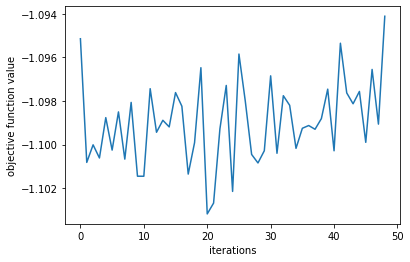

In [21]:
### optimizer
from quchem.Scipy_Optimizer import *

GG = Optimizer(VQE_experiment_ENERGY, theta_random_input, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

In [22]:
from quchem.Adam_Optimizer import *

In [23]:
def calc_gradient_ADAM(THETA):      

    Obs_PLUS = VQE_experiment_ENERGY(THETA + np.pi/4)
    Obs_MINUS = VQE_experiment_ENERGY(THETA - np.pi/4)
    
    gradient = Obs_PLUS - Obs_MINUS
        
    return gradient

In [26]:
X0 = random.uniform(0, 2*np.pi)

opt_params, list_of_inputs, list_of_outputs = Adam_Opt(X0, VQE_experiment_ENERGY,
                                                       calc_gradient_ADAM, 
                                                       learning_rate=0.05, 
                                                       beta_1=0.9, 
                                                       beta_2=0.999, 
                                                       epsilon=1e-8,
                                                       max_iter=50,
                                                       disp=True,
                                                       tolerance=1e-3,
                                                       store_steps=True)

VQE_experiment_ENERGY(opt_params)

step: 1 input:4.958856814359481 obj_funct: 0.032627822205021695
step: 2 input:5.003923046751713 obj_funct: 0.02193098325261511
step: 3 input:5.04930598278612 obj_funct: 0.009311674360952038
step: 4 input:5.095670309048297 obj_funct: -0.00787322588998729
step: 5 input:5.142784568621824 obj_funct: -0.030761185009352432
step: 6 input:5.190639711737854 obj_funct: -0.06331206933631445
step: 7 input:5.23923794056492 obj_funct: -0.09336496202464095
step: 8 input:5.288606492637213 obj_funct: -0.13581929302928347
step: 9 input:5.338721239700234 obj_funct: -0.17256300605797686
step: 10 input:5.389560506466312 obj_funct: -0.2199098173008593
step: 11 input:5.441104098993535 obj_funct: -0.27613387304519643
step: 12 input:5.493323315666643 obj_funct: -0.33312173582458005
step: 13 input:5.546182070074136 obj_funct: -0.39008718450749363
step: 14 input:5.599631654538628 obj_funct: -0.450006595488173
step: 15 input:5.653619700183844 obj_funct: -0.5104813105835178
step: 16 input:5.708074024393649 obj_fun

-1.0648543411487437

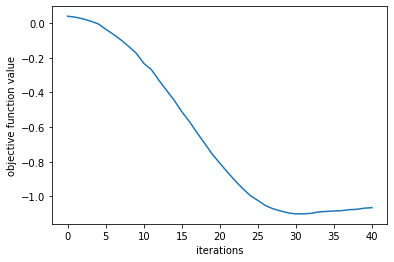

In [27]:
import matplotlib.pyplot as plt
# % matplotlib inline
plt.figure()
plt.plot(list_of_outputs)
plt.xlabel('iterations')
plt.ylabel('objective function value')
plt.show()